# 变量设置

In [194]:
# 设置数据集名称，对应 https://xenabrowser.net/datapages/ 中缩写
dataset_name =  ['LUAD', 'LUSC']
# 设置俩： ['LUAD', 'LUSC']
# 更多更多也行
# 单一个： ['LUAD'] 
# All possible Value:
# ['ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','GBM','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']:
method = 'normal' # diff是上面俩数据集的差异，normal是和正常样本的差异
# method = 'diff'
loglevel = ''
# loglevel = 'debug'

balance_input = 'true' # or true 
rate1 = 0.0

# 数据导入

## 库

In [195]:
import requests
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from typing import Tuple, List
from sklearn.metrics import  roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score
from imblearn.over_sampling import SMOTE, SMOTEN
sm = SMOTEN(random_state=42)
from multiprocessing import Pool, cpu_count
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet,ElasticNetCV,SGDClassifier,RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from IPython.display import display, HTML
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

In [196]:
def download_and_parse_data(dataset_name):
    pkl_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna_transposed.pkl'
    if os.path.exists(pkl_file_path):
        df_t = pd.read_pickle(pkl_file_path)
    else:
        url = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-" + dataset_name + ".mirna.tsv.gz"
        response = requests.get(url)
        os.makedirs('./datasets', exist_ok=True)
        gz_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv.gz'
        with open(gz_file_path, 'wb') as f_out:
            f_out.write(response.content)
        tsv_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv'
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(tsv_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        df = pd.read_csv(tsv_file_path, sep='\t')
        df_t = df.transpose()
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop(df_t.index[0])
        df_t = np.power(2, df_t) - 1
        df_t = df_t.round(4)
        df_t['Status'] = df_t.index.map(lambda x: 1 if x.split('-')[3][:2] == '01' else 0)
        df_t = df_t[['Status'] + [col for col in df_t.columns if col != 'Status']]
        df_t.to_pickle(pkl_file_path)
        os.remove(gz_file_path)
        os.remove(tsv_file_path)
    df_t = df_t.apply(pd.to_numeric)
    return df_t

def find_healthy_samples(df):
    healthy_samples_df = df[df['Status'] == 0]
    return healthy_samples_df

In [197]:
# balance_data
def getStatus0data():
    Status0data = pd.DataFrame()
    Status1data = pd.DataFrame()
    for datasets in ['LAML','ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','GBM','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']:
        if datasets in dataset_name:
            continue
        try:
            # use download_and_parse_data to download the data
            dataframe = download_and_parse_data(datasets)
            # 把Status为0的dataframe赋值给Status0data
            Status0data = pd.concat([Status0data, dataframe[dataframe['Status'] == 0]])
            Status1data = pd.concat([Status1data, dataframe[dataframe['Status'] == 1]])
        except:
            print('Error:', datasets)
            continue

    # 混入对应比例的1
    # Status0data = pd.concat([Status0data, Status1data.sample(len(Status0data)*rate1/(1-rate1))])
    # int is needed
    Status0data = pd.concat([Status0data, Status1data.sample(n=int(len(Status0data)*rate1/(1-rate1)),random_state=42)])
    # 把所有的label 都设为0
    Status0data['Status'] = 0
    # 保存0的dataframe为pkl文件
    pkl_file_path = './datasets/Status0data.pkl'
    Status0data.to_pickle(pkl_file_path)

    return Status0data

def balance_data(Currentdata):
    # Get the count of Status=0 and Status=1
    current1 = Currentdata[Currentdata['Status'] == 1]
    current0 = Currentdata[Currentdata['Status'] == 0]
    
    if len(current0) > len(current1):
        print('0 is more than 1')
        # No need to balance, return the original DataFrame
        return Currentdata
    else:
        print('1 is more than 0')
        # If 1 is more, randomly sample from Status=0 data and concatenate
        Status0data = getStatus0data()
        balanced_data = pd.concat([current1, Status0data.sample(n=len(current1) - len(current0),random_state=42)])
        print('Currentdata.shape:', balanced_data.shape)
        return balanced_data

def balance_data2(Currentdata):
    # Get the count of Status=0 and Status=1
    current1 = Currentdata[Currentdata['Status'] == 1]
    current0 = Currentdata[Currentdata['Status'] == 0]
    
    if len(current0) > len(current1):
        print('0 is more than 1')
        # No need to balance, return the original DataFrame
        return Currentdata
    else:
        print('1 is more than 0')
        # If 1 is more, randomly remove some Status=1 data and concatenate
        balanced_data = pd.concat([current0, current1.sample(n=len(current0),random_state=42)])
        print('Currentdata.shape:', balanced_data.shape)
        return balanced_data




In [198]:
if method == "diff":
    dataA = download_and_parse_data(dataset_name[0])
    dataB = download_and_parse_data(dataset_name[1])

    A_up = dataA[dataA['Status'] == 1]
    B_up = dataB[dataB['Status'] == 1]

    B_up['Status'] = 0
    df_transposed = pd.concat([A_up, B_up], ignore_index=True)
elif method == "normal":
    df_transposed = pd.DataFrame()
    for name in dataset_name:
        df_transposed = df_transposed.append(download_and_parse_data(name))

# if balance_input, we need to balance the data using different datasets.
if balance_input == 'true':
    df_transposed = balance_data(df_transposed)
    
train_data = df_transposed.apply(pd.to_numeric)

1 is more than 0
Currentdata.shape: (1895, 1882)


## 函数 准备

#### 定义存储结果的DataFrame

In [199]:
final_results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'confusionmatrix','coef', 'coef_rounded', 'found_coef', 'multiple_times','intercept', 'miRNA_ID'])

#### 可接受的权重的范围筛选器

In [200]:
def get_allowed_numbers(max_n=25,allowed_factors=[1,2,3,4,5]):
    # 100 以内的整数
    result = range(1,100)
    return result

def is_all_in_list(list,n=25,allowed_factors=[2,3,5]):
    for i in list:
        if i not in get_allowed_numbers(n,allowed_factors):
            return False
    return list

### 画图

分数分布图

In [201]:
plot_labels = ['得了', '没得']

In [202]:
def plot_score_distribution(ax, y_score, final_Status):                                 # 这个函数负责处理分数分布图这一个小图
    ax.scatter(range(len(y_score)), y_score, c=final_Status, cmap='bwr', alpha=0.5)     # 画散点图，x轴是样本序号，y轴是分数，颜色是感染情况，颜色映射是蓝白红，透明度是0.5
                                                                                        # x是样本序号：分开画，免得都黏在一起了，透明度的设置是一样的原因。
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei']                                          # 中文乱码
    plt.rcParams['axes.unicode_minus']=False                                            # 负号乱码
    labels = plot_labels                                                                # 图例标签，这里是感染情况，以后如果换了的话得改。 #todo 将这个改为传入参数
    ax.legend(labels, loc='upper right')                                                # 图例
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')         # 以0.5为界，画一条虚线，表示分数大于0.5的是细菌感染，小于0.5的是病毒感染，这个以后也得改
                                                                                        # 因为不同的模型（如linear regression 和 ridge regression）的判断标准不一样，所以这个界限也不一样。
                                                                                        # 现在的做法是直接在y_score 上做手脚，还是……蛮不优雅的，但是先这样吧。
                                                                                        # todo 将这个改为传入参数

ROC曲线

In [203]:
def plot_roc_curve(ax, y_score, final_Status):
    from sklearn.metrics import auc
    fpr, tpr, thresholds = roc_curve(final_Status, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

PR曲线

In [204]:
def plot_pr_curve(ax, y_score, final_Status):
    precision, recall, thresholds = precision_recall_curve(final_Status, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

混淆矩阵

In [205]:
def plot_confusion_matrix(ax, y_score, final_Status):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_Status, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues) # type: ignore
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, plot_labels, rotation=45)
    plt.yticks(tick_marks, plot_labels)
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

分数分布图、ROC曲线、PR曲线和混淆矩阵

In [206]:
def plot_all(score, Status, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))                                                     # 规定画布大小为1200*1200px，分成2*2的4个小图
    fig.suptitle(title, fontsize=16)                                                                    # 设置标题
    plot_score_distribution(axs[0,0], score, Status)                                                    # 第一个小图（左上角）是分数分布图 这里的axs[0,0]是指第一行第一列的小图，注意计数是从0开始的。
    plot_roc_curve(axs[0,1], score, Status)                                                             # 第二个小图（右上角）是ROC曲线
    plot_pr_curve(axs[1,0], score, Status)                                                              # 第三个小图（左下角）是PR曲线
    plot_confusion_matrix(axs[1,1], score, Status)                                                      # 第四个小图（右下角）是混淆矩阵
    if feature or weight:                                                                               # 如果有feature或者weight的话，就在图的下方加上文字
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)                                                            # 调整图的下边距，这样文字就不会挡住图了
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)     # 在图的下方加上文字，这里的0.5,0.04是指文字的位置，ha='center'是指文字居中，va='bottom'是指文字在底部，fontsize=12是指文字大小
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=8)          # 同上
        except:
            pass                                                                                        # 如果出错了就算了
    return fig, axs

##### 给定 基因 权重 和数据，计算分数并画图（可能需要修改）

### 筛选

筛选哪些基因比较有差异

In [207]:
def get_higher_columns(data, diff=2.0):
    data_mean = data.groupby('Status').mean()
    higher_columns = []
    higher_times = []
    for i in range(data_mean.shape[1]):
        if  diff*data_mean.iloc[0,i] < data_mean.iloc[1,i]  or data_mean.iloc[0,i] > diff*data_mean.iloc[1,i]:
            higher_columns.append(data_mean.columns[i])
            # 0
            if data_mean.iloc[0,i] == 0:
                higher_times.append(1e10)
            else:
                higher_times.append(data_mean.iloc[1,i]/data_mean.iloc[0,i])
    return higher_columns, higher_times

排序有差异的基因

In [208]:
def sort_higher_columns(data, higher_columns, higher_times):
    # sort the columns and times together
    data_higher_times, data_higher_columns = zip(*sorted(zip(higher_times, higher_columns), reverse=True))
    # convert data_higher_columns to list
    data_higher_columns = list(data_higher_columns)
    # add Status column to the top of data_higher_columns
    data_higher_columns.append('Status')
    # get the new data
    data_higher = data[data_higher_columns]
    return data_higher, data_higher_times

输出

In [209]:
def print_best_acc(test_acc, n, gene_symbol, coef):
    best_acc = max(test_acc)
    best_i = 0
    i = 0
    print('最好的准确率为：', best_acc)
    for acc in test_acc:
        if acc == best_acc:
            print('='*60)
            print('对应的特征数为：', n[i],'方法为：', methods[i // len(models)].__name__,'特征为：', gene_symbol[i])
            print('模型为：', models[i % len(models)],'特征权重为：', coef[i])
            weights_avg = np.mean(coef[i])
            new_coefs = []
            for j in range(len(coef[i])):
                # new_coefs.append(10*(coef[i][j]/weights_avg)) 保留2位小数
                # new_coefs.append(round(10*(coef[i][j]/weights_avg), 2)) type numpy.ndarray doesn't define __round__ method
                new_coefs.append(np.round(10*(coef[i][j]/weights_avg), 2))
            print('比例大致为：', new_coefs)
        i += 1

一次性完成基因筛选和模型训练
通过调控C，使用LogisticRegression or LinearSVC 一次性完成基因筛选和模型训练

In [210]:
def percent_to_color(percent: float) -> str:
    assert 0 <= percent <= 1, "Percent must be between 0 and 1"
    if percent >= 0.82:
        hue = int(120 - (1 - percent) * 4000 / 3)
    else:
        hue = 0
    saturation = 100  # 饱和度为100%
    lightness = 50  # 亮度为50%
    return f"hsl({hue}, {saturation}%, {lightness}%)"

def colored_text(text: str, percent: float) -> str:
    color = percent_to_color(percent)
    return f'<span style="color: {color}">{text}</span>'
def evaluate_classifier(clf, method, model, X_train, y_train, X_test, y_test, params):
    global final_results

    acc_scores, auc_scores, f1_scores, precision_scores, recall_scores, n_features = [], [], [], [], [], []

    for param in params:
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        nonzero_coef_indices = np.flatnonzero(clf.coef_)  # Indices where coef_ != 0
        n = len(nonzero_coef_indices)
        y_pred = clf.predict(X_test)
        y_pred = np.array([1 if i > 0.5 else 0 for i in y_pred], dtype=int)
        
        if 1 <= n <= 20:
            cm = confusion_matrix(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            f2 = fbeta_score(y_test, y_pred, beta=2)
            f05 = fbeta_score(y_test, y_pred, beta=0.5)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            # acc = clf.score(X_test, y_test) if method is lasso or elasticnet, score is not accuracy
            acc = accuracy_score(y_test, y_pred)

            coef = clf.coef_
            # only use non-zero coef
            coef = coef[coef != 0]
            weights_avg = np.mean(np.abs(coef))
            max_times = 100 / np.max(np.abs(coef))
            multipletimes = [max_times]
            found_coef = False
            coef_roundeds = []
            deltas = []
            for multipletime in multipletimes:
                coef_rounded_t = []
                differences = []
                for coef_i in coef:
                    # 符号问题,先存符号
                    coef_i_sign = coef_i / np.abs(coef_i)
                    coef_i = np.abs(coef_i)
                    coef_rounded_t.append(coef_i * multipletime * coef_i_sign)
                    differences.append(0)  # 不再使用 allowed_numbers
                delta = np.average(np.array(differences))
                deltas.append(delta)
                coef_roundeds.append(coef_rounded_t)

            coef_rounded = coef_roundeds[np.argmin(deltas)]
            delta = np.min(deltas)
            mean_coef = np.mean(np.abs(coef_rounded))
            times = mean_coef / weights_avg
            if delta < 0.30: # 30%的平均误差
                found_coef = True
            if np.sum(coef_rounded) == 0:
                balanced = True
            else:
                balanced = False

            intercept = clf.intercept_

            nonzero_coef_indices = np.flatnonzero(clf.coef_) # get the indices of non-zero coef
            gene_id = list(X_train.columns[nonzero_coef_indices])

            result = pd.DataFrame({
                'method': [method],
                'model': [model],
                'n': [n],
                'acc': [acc],
                'auc': [auc],
                'f1': [f1],
                'f2': [f2],
                'f05': [f05],
                'precision': [precision],
                'recall': [recall],
                'confusionmatrix': [cm],
                'coef': [coef.tolist()],
                'coef_rounded': [coef_rounded],
                'found_coef': [found_coef],
                'delta': [delta],
                'multiple_times': [times],
                'intercept': [intercept.item()],
                'balanced': [balanced],
                'gene_id': [gene_id],
            })

            final_results = pd.concat([final_results, result], ignore_index=True) 

            # For plotting
            n_features.append(n) 
            acc_scores.append(acc)
            auc_scores.append(auc)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)

            if loglevel == 'debug':
                result_text = ""
                result_text += f'method: {method}, '
                result_text += f'model: {model}, '
                result_text += f'n: {n}, '
                result_text += 'acc: ' + colored_text(f'{acc:.3f}', acc) + ', '
                result_text += 'auc: ' + colored_text(f'{auc:.3f}', auc) + ', '
                result_text += 'f1: ' + colored_text(f'{f1:.3f}', f1) + ', '
                result_text += 'precision: ' + colored_text(f'{precision:.3f}', precision) + ', '
                result_text += 'recall: ' + colored_text(f'{recall:.3f}', recall) + '<br>'
                coef_text = 'coef: '+ coef_rounded.__str__() + 'Gene: ' + gene_id.__str__()
                result_text += coef_text
                # 对 coef 和 gene_id 同样这样处理
                # 最后，一次性打印所有的结果
                display(HTML(result_text))
        if n > 22:
            break

    # Plotting inside the function
    plt.figure(figsize=(10,6))
    plt.plot(n_features, auc_scores, label='AUC')
    plt.scatter(n_features, auc_scores)
    plt.plot(n_features, f1_scores, label='F1 score')
    plt.scatter(n_features, f1_scores)
    plt.plot(n_features, precision_scores, label='Precision', linestyle='dashed')
    plt.plot(n_features, recall_scores, label='Recall', linestyle='dashed')
    plt.title('Performance metrics by number of features (' + method + ')')
    plt.xlabel('Number of features')
    plt.ylabel('Performance metrics')
    plt.legend()
    plt.grid()
    plt.show()

## 训练

In [211]:
higher_columns, higher_times = get_higher_columns(train_data, 2)
print('高表达差异基因数目：', len(higher_columns))

高表达差异基因数目： 788


根据倍率不同进行排序

In [212]:
data_higher, data_higher_times = sort_higher_columns(train_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['Status'], axis=1), data_higher['Status'], test_size=0.2, random_state=42)
# X_train, y_train = sm.fit_resample(data_higher, data_higher['Status'])
# smote
# X_train, y_train = sm.fit_resample(X_train, y_train)
# X_test, y_test= sm.fit_resample(X_test, y_test)


In [213]:
def calculate_correlation(train_data):
    status = train_data.iloc[:, 0]
    other_columns = train_data.iloc[:, 1:]
    correlations = {}

    for column in other_columns.columns:
        data = other_columns[column]
        corr, _ = pearsonr(status, data)
        if not pd.isnull(corr):
            correlations[column] = corr

    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:] 

    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column', 'Correlation'])
    correlation_df = correlation_df.rename(columns={'Column': 'gene_id'})
    correlation_df.to_csv('correlation_results.csv', index=False)
    print("Correlation results saved to correlation_results.csv")
calculate_correlation(train_data)



Correlation results saved to correlation_results.csv


### 训练不同的模型，使用不同的特征选择方法，选择出特征后，使用不同的方法来训练模型

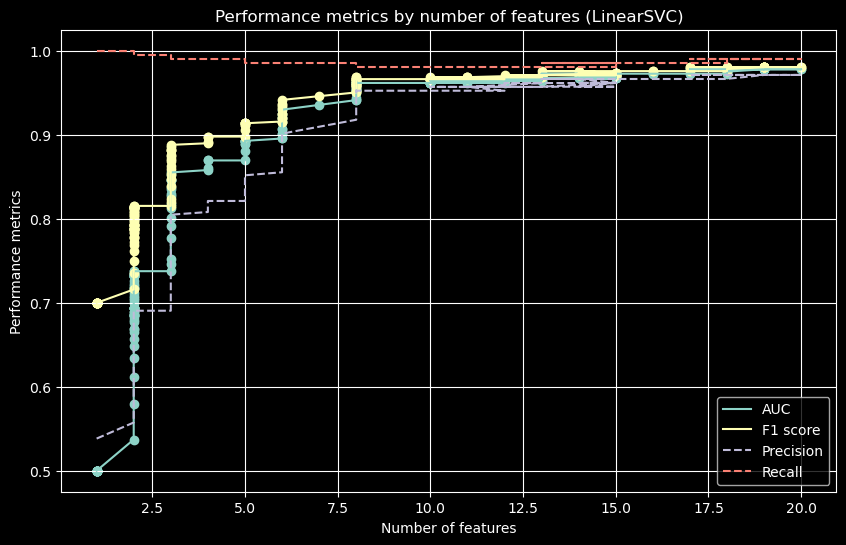

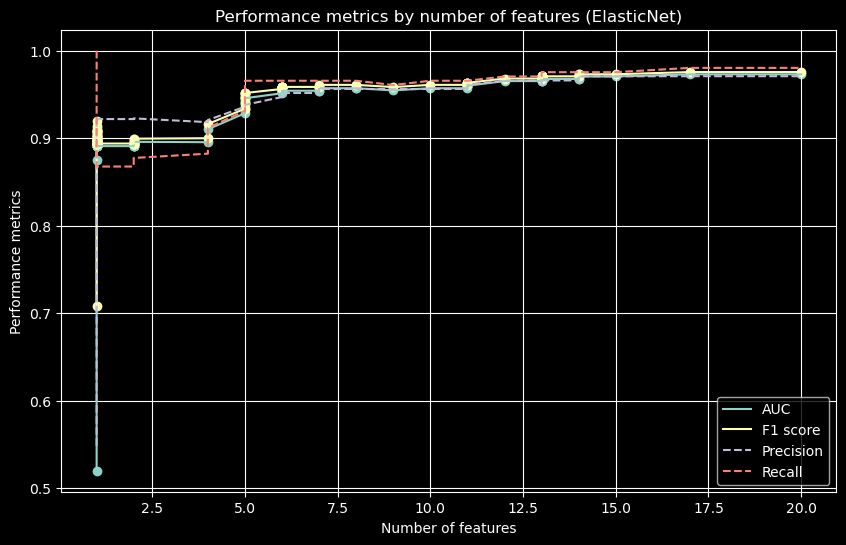

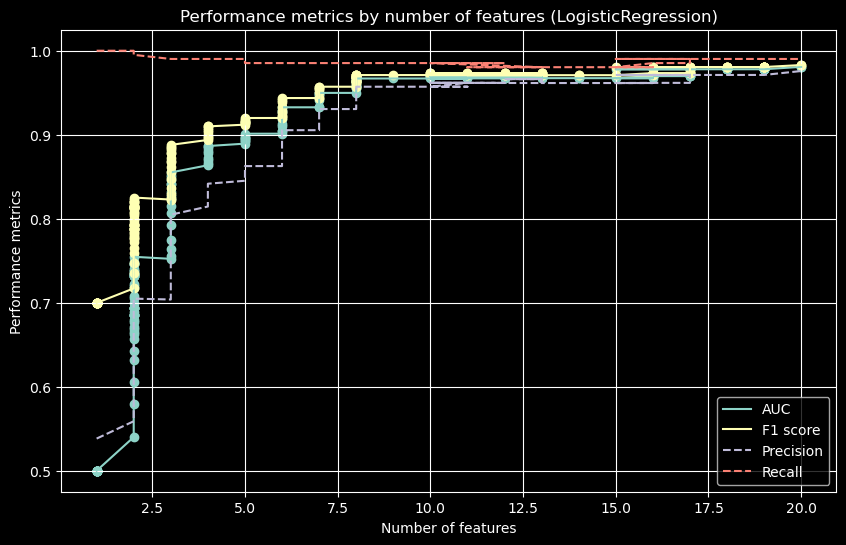

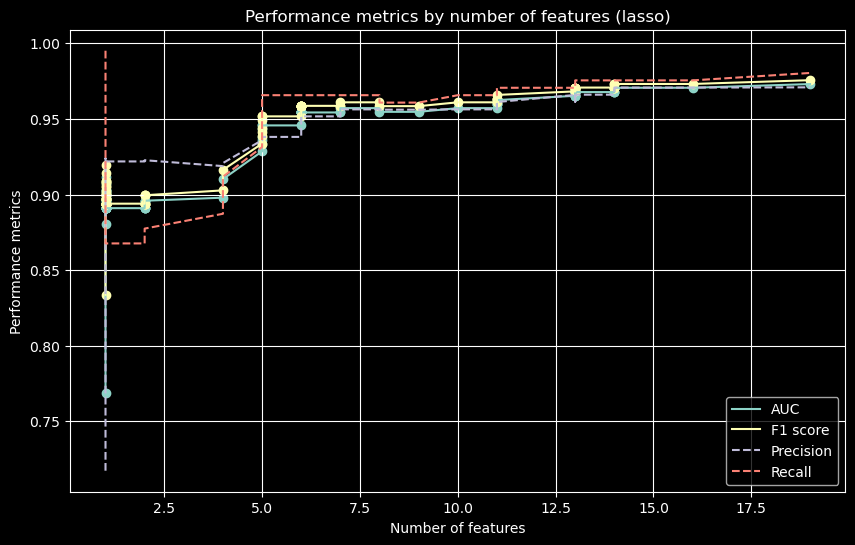

In [214]:
final_results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'f2','f05', 'confusionmatrix','coef', 'coef_rounded', 'found_coef', 'multiple_times','delta','intercept','balanced', 'gene_id'])
max_run_num = 600
C_values = np.logspace(-9, 0, num=max_run_num, base=10)
alpha_values = np.logspace(15, -5, num=max_run_num, base=10)

# LinearSVC
lsvc = LinearSVC(penalty="l1", dual=False)
lsvc_params = [{'C': C} for C in C_values]
evaluate_classifier(lsvc, 'LinearSVC', 'lsvc', X_train, y_train, X_test, y_test, lsvc_params)
# Elastic-Net
#    encv = ElasticNetCV(l1_ratio=1-np.logspace(-3, -0.1, num=10, base=10), n_alphas=200, max_iter=5000, n_jobs=10, selection='cyclic')
#    encv.fit(X_train, y_train)
#    print('-'*60)
#    print('ElasticNetCV')
#    print('best l1_ratio:', encv.l1_ratio_)
#    print('selected features:', X_train.columns[encv.coef_ != 0].values)
#    print('n features:', encv.n_features_in_)
en = ElasticNet(alpha=0.1, l1_ratio=0.75, max_iter=5000, selection='cyclic')
en_params = [{'alpha': alpha} for alpha in alpha_values]
evaluate_classifier(en, 'ElasticNet', 'en', X_train, y_train, X_test, y_test, en_params)
# LogisticRegression
#       lrcv = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=10000, n_jobs=-1)
#       lrcv.fit(X_train, y_train)
#       print('-'*60)
#       print('LogisticRegressionCV')
#       print('best C:', lrcv.C_)
# print('selected features:', X_train.columns[lrcv.coef_ != 0].values)
# print('n features:', lrcv.n_features_in_)
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr_params = [{'C': C} for C in C_values]
evaluate_classifier(lr, 'LogisticRegression', 'lr', X_train, y_train, X_test, y_test, lr_params)
# Lasso
#       lassocv = LassoCV(max_iter=5000, n_jobs=-1)
#       lassocv.fit(X_train, y_train)
#       print('-'*60)
#       print('LassoCV')
#       print('best alpha:', lassocv.alpha_)
#       print('selected features:', X_train.columns[lassocv.coef_ != 0].values)
#       print('n features:', lassocv.n_features_in_)
lasso = Lasso(alpha=0.1, max_iter=5000)
lasso_params = [{'alpha': alpha} for alpha in alpha_values]
evaluate_classifier(lasso, 'lasso', 'lasso', X_train, y_train, X_test, y_test, lasso_params)


In [215]:
# 重新排序
sort_columns = ['found_coef','f1', 'auc',  'balanced','n', 'delta']
sort_order = [False,False, False, False,True, True]

# Sort the DataFrame
results_sorted = final_results.sort_values(by=sort_columns, ascending=sort_order).reset_index(drop=True).copy()
results_sorted_view = results_sorted.head(5).copy().drop(['coef','gene_id','intercept','multiple_times'], axis=1)
# results_sorted_view

# 复制 'final_results' 到 'final_results_unique' 
final_results_unique = results_sorted.copy()

# 将 'coef_rounded' 和 'gene_id' 列转化为字符串
final_results_unique['coef_rounded'] = final_results_unique['coef_rounded'].astype('str')
final_results_unique['gene_id'] = final_results_unique['gene_id'].astype('str')

# 删除重复行
final_results_unique.drop_duplicates(subset=['coef_rounded', 'gene_id'], keep='first', inplace=True)
final_results_unique['coef_rounded'] = final_results_unique['coef_rounded'].apply(ast.literal_eval)
final_results_unique['gene_id'] = final_results_unique['gene_id'].apply(ast.literal_eval)

In [216]:
# reproduce
results_sorted_found_coef = final_results_unique[results_sorted['found_coef'] == True].reset_index(drop=True).copy()
reperduce = []
for i in range(len(results_sorted_found_coef)):
    gene_ids = results_sorted_found_coef['gene_id'][i]
    # check if gene_ids are in X_test columns
    if set(gene_ids).issubset(set(X_test.columns)):
        X_test_selected = X_test[gene_ids].copy()
    else:
        # modify gene_ids to match X_test columns
        gene_ids = [col for col in gene_ids if col in X_test.columns]
        X_test_selected = X_test[gene_ids].copy()
    y_test_selected = y_test
    # calculate score
    coef = results_sorted_found_coef['coef_rounded'][i]
    times = results_sorted_found_coef['multiple_times'][i]
    intercept = results_sorted_found_coef['intercept'][i]
    model_name = results_sorted_found_coef['model'][i]

    scores = []
    predictions = []
    
    # determine model and calculate scores and predictions
    if model_name == 'LinearRegression':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'RidgeClassifier' or model_name == 'RidgeClassifierCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LogisticRegression' or model_name == 'LogisticRegressionCV':
        for j in range(len(X_test_selected)):
            z = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            score = 1 / (1 + np.exp(-z))
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'Lasso' or model_name == 'LassoCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LinearSVC' or model_name == 'NuSVC':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'ElasticNet':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'SGDClassifier':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    else:
        # handle SVC
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
        
    # calculate evaluation metrics
    acc = accuracy_score(y_test_selected, predictions)
    auc = roc_auc_score(y_test_selected, scores)
    f1 = f1_score(y_test_selected, predictions)
    precision = precision_score(y_test_selected, predictions)
    recall = recall_score(y_test_selected, predictions)

    # 能复现
    if acc == results_sorted_found_coef['acc'][i] and f1 == results_sorted_found_coef['f1'][i]:
        can_reproduce = True
    else:
        can_reproduce = False
    # can_reproduce = True

    # if not acc == results_sorted_found_coef['acc'][i]:
    #     can_reproduce = False
    #     # print results
    #     print('Model:', model_name, 'n:', results_sorted_found_coef['n'][i],'acc:', acc, 'auc:', auc, 'f1:', f1, 'precision:', precision, 'recall:', recall)
    #     print(acc)
    #     print(results_sorted_found_coef['acc'][i])
    
    reperduce.append(can_reproduce)

results_sorted_found_coef['reproduce'] = reperduce
results_sorted_found_coef_view = results_sorted_found_coef[results_sorted_found_coef['reproduce'] == True][results_sorted_found_coef['n'] <= 15].copy().drop(['coef','intercept','multiple_times'], axis=1)
results_sorted_found_coef_view

,method,model,n,acc,auc,f1,precision,recall,f2,f05,confusionmatrix,coef_rounded,found_coef,delta,balanced,gene_id,reproduce
83,ElasticNet,en,14,0.970976,0.970602,0.973105,0.970732,0.975490,0.974535,0.971680,"[[169, 6], [5, 199]]","[100.0, 64.64265863081592, 35.65756484968031, ...",True,0.0,False,"[hsa-mir-183, hsa-mir-205, hsa-mir-182, hsa-mi...",True
84,ElasticNet,en,14,0.970976,0.970602,0.973105,0.970732,0.975490,0.974535,0.971680,"[[169, 6], [5, 199]]","[100.0, 64.85617384595606, 34.32854054083771, ...",True,0.0,False,"[hsa-mir-183, hsa-mir-205, hsa-mir-182, hsa-mi...",True
85,lasso,lasso,14,0.970976,0.970602,0.973105,0.970732,0.975490,0.974535,0.971680,"[[169, 6], [5, 199]]","[100.0, 64.70103644361696, 35.303201058798194,...",True,0.0,False,"[hsa-mir-183, hsa-mir-205, hsa-mir-182, hsa-mi...",True
86,lasso,lasso,14,0.970976,0.970602,0.973105,0.970732,0.975490,0.974535,0.971680,"[[169, 6], [5, 199]]","[100.0, 64.908929068564, 34.008595743601184, 9...",True,0.0,False,"[hsa-mir-183, hsa-mir-205, hsa-mir-182, hsa-mi...",True
87,ElasticNet,en,15,0.970976,0.970602,0.973105,0.970732,0.975490,0.974535,0.971680,"[[169, 6], [5, 199]]","[100.0, 65.04698810578452, 33.1326787954327, 9...",True,0.0,False,"[hsa-mir-183, hsa-mir-205, hsa-mir-182, hsa-mi...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,ElasticNet,en,2,0.889182,0.890966,0.893939,0.921875,0.867647,0.877976,0.910494,"[[160, 15], [27, 177]]","[100.0, -5.1822703130503385]",True,0.0,False,"[hsa-mir-21, hsa-mir-10b]",True
328,lasso,lasso,2,0.889182,0.890966,0.893939,0.921875,0.867647,0.877976,0.910494,"[[160, 15], [27, 177]]","[100.0, -0.5185403265192969]",True,0.0,False,"[hsa-mir-21, hsa-mir-10b]",True
329,lasso,lasso,2,0.889182,0.890966,0.893939,0.921875,0.867647,0.877976,0.910494,"[[160, 15], [27, 177]]","[100.0, -2.3387296578703807]",True,0.0,False,"[hsa-mir-21, hsa-mir-10b]",True
330,lasso,lasso,2,0.889182,0.890966,0.893939,0.921875,0.867647,0.877976,0.910494,"[[160, 15], [27, 177]]","[100.0, -4.019911743089433]",True,0.0,False,"[hsa-mir-21, hsa-mir-10b]",True


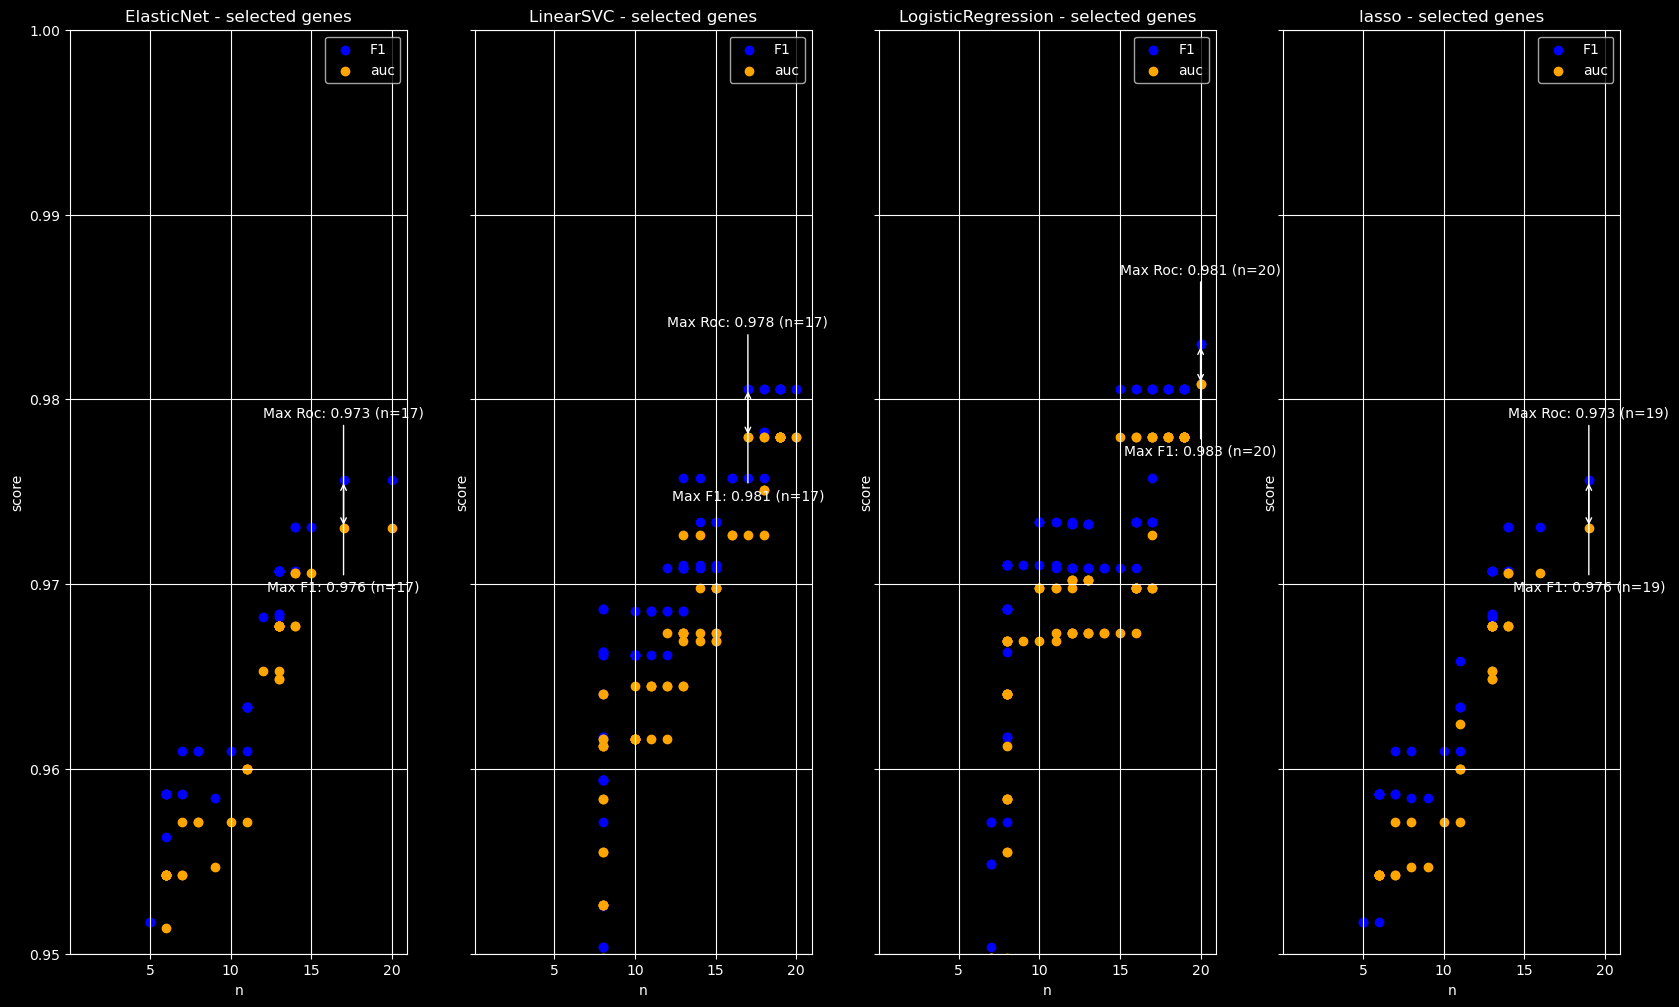

In [217]:
# for results_sorted_found_coef, draw the figure
# Group the results by method and model
# filter by n
results_sorted_found_coef_n = results_sorted_found_coef[results_sorted_found_coef['n'] <= 25]
groups = results_sorted_found_coef_n.groupby(['method'])
methods = [method for method, _ in groups]
# Create a figure with multiple subplots
fig, axs = plt.subplots(1,len(methods), sharex=True, sharey=True, figsize=(20, 12))

# Iterate over the subplots and plot the acc and roc values
for i, method in enumerate(methods):
    group = groups.get_group(method)
    axs[i].scatter(group['n'], group['f1'], label='F1', color='blue')
    axs[i].scatter(group['n'], group['auc'], label='auc', color='orange')
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('score')
    axs[i].set_ylim([0.95, 1.00]) # Set y-axis limits
    axs[i].legend()
    # Find the maximum acc and roc values for this method and model
    max_acc_idx = group['f1'].idxmax()
    max_auc_idx = group['auc'].idxmax()
    max_acc = group.loc[max_acc_idx, 'f1']
    max_auc = group.loc[max_auc_idx, 'auc']
    max_n_acc = group.loc[max_acc_idx, 'n']
    max_n_auc = group.loc[max_auc_idx, 'n']

    # Add annotations with the maximum acc and roc values
    axs[i].annotate(f'Max F1: {max_acc:.3f} (n={max_n_acc})',
                        xy=(max_n_acc, max_acc),
                        xytext=(max_n_acc, max_acc - 0.006),
                        ha='center',
                        arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f'Max Roc: {max_auc:.3f} (n={max_n_auc})',
                        xy=(max_n_auc, max_auc),
                        xytext=(max_n_auc, max_auc + 0.006),
                        ha='center',
                        arrowprops=dict(arrowstyle='->'))

    axs[i].set_title(f'{method} - selected genes')
    # grid
    axs[i].grid()

# 导出保存

In [218]:
def calthreadhold( model_name, instances, times):
    if model_name == 'LinearRegression':
        threshold = (0.5 - instances) * times
    elif model_name == 'RidgeClassifier' or model_name == 'RidgeClassifierCV':
        threshold = (0.5 - instances) * times
    elif model_name == 'LogisticRegression' or model_name == 'LogisticRegressionCV':
            threshold = (0 - instances) * times
    elif model_name == 'lasso' or model_name == 'LassoCV':
        threshold = (0.5 - instances) * times
    elif model_name == 'LinearSVC' or model_name == 'NuSVC':
        threshold = (0.5 - instances) * times
    elif model_name == 'ElasticNet':
        threshold = (0.5 - instances) * times
    elif model_name == 'SGDClassifier':
        threshold = (0.5 - instances) * times
    else:
        threshold = (0.5 - instances) * times
    return threshold

In [219]:
# # 计算f1值的60%分位数
# quantile_60 = results_sorted_found_coef['f1'].quantile(0.6)
# 
# # 过滤results_sorted_found_coef，只保留f1值在前60%的数据
# filtered_results = results_sorted_found_coef[results_sorted_found_coef['f1'] >= quantile_60]
# filtered_results
filtered_results = results_sorted_found_coef[results_sorted_found_coef['reproduce'] == True].copy()
filtered_results['threshold'] = filtered_results.apply(lambda x: calthreadhold(x['model'], x['intercept'], x['multiple_times']), axis=1)

In [220]:
# import excel 
import openpyxl
# 时间
import time
xsl_file = str(dataset_name) + time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.xlsx'
# 检查文件是否存在
import os
if os.path.exists(xsl_file):
    os.remove(xsl_file)
wb = openpyxl.Workbook()
ws = wb.active
try:
    ws = wb['Results']
except KeyError:
    ws = wb.create_sheet('Results')
# remove all rows
ws.delete_rows(1, ws.max_row)
# write column name
for col in range(len(filtered_results.columns)):
    ws.cell(row=1, column=col+1, value=filtered_results.columns[col])
# write data
for i in range(len(filtered_results)):
    for col in range(len(filtered_results.columns)):
        # not NaN
        if filtered_results.iloc[i, col] == '':
            ws.cell(row=i+2, column=col+1, value='N/A')
        else:
            try:
                ws.cell(row=i+2, column=col+1, value=filtered_results.iloc[i, col])
            except ValueError:
                ws.cell(row=i+2, column=col+1, value=str(filtered_results.iloc[i, col]))

In [221]:
# 创建一个默认字典来存储每个列表的f1值的总和、计数、最大f1值和对应的其他值
f1_dict = defaultdict(lambda: [0, 0, 0, float('inf'), 0, 0, 0, None])

# 遍历filtered_results，更新f1_dict
for _, row in filtered_results.iterrows():
    key = tuple(row['gene_id'])
    f1_dict[key][0] += row['f1']
    f1_dict[key][1] += 1
    if row['f1'] > f1_dict[key][2] or (row['f1'] == f1_dict[key][2] and row['intercept'] < f1_dict[key][3]):
        f1_dict[key][2] = row['f1']
        f1_dict[key][3] = row['intercept']
        f1_dict[key][4] = row['coef_rounded']
        f1_dict[key][5] = row['multiple_times']
        f1_dict[key][6] = row['delta']
        f1_dict[key][7] = row['model']

# 创建一个空的DataFrame
df = pd.DataFrame(columns=['List', 'Length', 'Count', 'Average F1 Score', 'Max F1 Score','Best Coef',  'Best Intercept', 'Best Multiple Times', 'Best Delta', 'Best Model'])

# 将f1_dict的内容添加到DataFrame中
for key, value in f1_dict.items():
    df = df.append({'List': list(key), 'Length': len(key), 'Count': value[1], 'Average F1 Score': value[0] / value[1], 'Max F1 Score': value[2], 'Best Intercept': value[3], 'Best Coef': value[4], 'Best Multiple Times': value[5], 'Best Delta': value[6], 'Best Model': value[7]}, ignore_index=True)

# 按照长度和出现次数进行排序
df = df.sort_values(by=['Length', 'Count'])

In [222]:
try:
    ws = wb['Sheet1']
except KeyError:
    ws = wb.create_sheet('Sheet1')
# remove all rows
ws.delete_rows(1, ws.max_row)
# write column name
for col in range(len(df.columns)):
    ws.cell(row=1, column=col+1, value=df.columns[col])
# write data
for i in range(len(df)):
    for col in range(len(df.columns)):
        # not NaN
        if df.iloc[i, col] == '':
            ws.cell(row=i+2, column=col+1, value='N/A')
        else:
            try:
                ws.cell(row=i+2, column=col+1, value=df.iloc[i, col])
            except ValueError:
                ws.cell(row=i+2, column=col+1, value=str(df.iloc[i, col]))

In [223]:
gene_data = pd.DataFrame()
# count
miRNAs = filtered_results['gene_id'].tolist()
# 统计出现次数 miRNAs_count as a dict
miRNAs_count = {}
for miRNA in miRNAs:
    # miRNA is a list
    # Add length of miRNA to miRNA
    for miRNA_ in miRNA:
        if miRNA_ in miRNAs_count:
            miRNAs_count[miRNA_] += 1
        else:
            miRNAs_count[miRNA_] = 1

miRNAs_count = sorted(miRNAs_count.items(), key=lambda x: x[1], reverse=True)
miRNAs_count = pd.DataFrame(miRNAs_count, columns=['gene_id', 'count'])

In [224]:
try:
    ws = wb['Count']
except KeyError:
    ws = wb.create_sheet('Count')
# remove all rows
ws.delete_rows(1, ws.max_row)
# write column name
df = miRNAs_count
for col in range(len(df.columns)):
    ws.cell(row=1, column=col+1, value=df.columns[col])
# write data
for i in range(len(df)):
    for col in range(len(df.columns)):
        # not NaN
        if df.iloc[i, col] == '':
            ws.cell(row=i+2, column=col+1, value='N/A')
        else:
            try:
                ws.cell(row=i+2, column=col+1, value=df.iloc[i, col])
            except ValueError:
                ws.cell(row=i+2, column=col+1, value=str(df.iloc[i, col]))
# save
# delete default sheet
wb.remove(wb['Sheet'])

wb.save(xsl_file)

### 绘图

In [232]:
# 选择的模型
# 实际输入的模型
select = results_sorted_found_coef[results_sorted_found_coef['reproduce'] == True][results_sorted_found_coef['n'] <=10].copy().iloc[0]
feature = select.gene_id
print("feature =", feature)
weight = select.coef_rounded
print("weight =", weight)
times = select.multiple_times
print('times =', times)
intercept = select.intercept
print('intercept =', intercept)
model = select.model
print('model =', model)

feature = ['hsa-mir-182', 'hsa-mir-203a', 'hsa-mir-21', 'hsa-mir-375', 'hsa-mir-30a', 'hsa-mir-142', 'hsa-mir-10b']
weight = [100.0, 18.948751967800256, 31.398435678561572, 16.58836997406416, 1.1932236242230176, -13.325413106320044, -5.110073513062845]
times = 15503000.833279924
intercept = -0.06416861065756818
model = en


In [233]:
ID = feature.copy()
ID.append("Status")
ID = np.array(ID).reshape(-1)
ID.astype('str')
testdata = pd.concat([X_test, y_test], axis=1)[ID]
# testdata = train_data[ID]

In [234]:
# 对平均值都乘以权重
weight = weight + [1]
testdata_weight = testdata * weight
weight = weight[:-1]
testdata_weight['score'] = testdata_weight.sum(axis=1) / times + intercept
if model == 'lr':
    testdata_weight['score'] = testdata_weight['score'].apply(lambda x: 1 / (1 + np.exp(-x)))
testdata_weight['prediction'] = testdata_weight['score'].apply(lambda x: 1 if x > 0.5 else 0)

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
def plot_metrics(testdata_weight, feature, weight):
    # 创建一个figure并添加4个子图（ax）
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # 在第一个子图上绘制分数分布图
    scatter = axs[0, 0].scatter(range(len(testdata_weight['score'])), testdata_weight['score'], c=testdata_weight['Status'], cmap='bwr', alpha=0.5)
    axs[0, 0].plot([0, len(testdata_weight['score'])], [0.5, 0.5], color='white', lw=1, linestyle='')
    axs[0, 0].set_title('Score distribution')
    c = {0: 'navy', 1: 'red'};ls = ['Negative', 'Positive']
    ele = [plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=c[i], markersize=7, label=label) for i, label in enumerate(ls)]
    legend1 = axs[0, 0].legend(handles=ele, loc='upper right')
    axs[0, 0].add_artist(legend1)
    #legend1 = axs[0, 0].legend(['Positive', 'Negative','Threshold'], loc="upper right")
    #axs[0, 0].add_artist(legend1)

    # 在第二个子图上绘制ROC曲线
    fpr, tpr, _ = roc_curve(testdata_weight['Status'], testdata_weight['score'])
    roc_auc = auc(fpr, tpr)
    axs[0, 1].plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
    axs[0, 1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[0, 1].set_xlim([0.0, 1.0])
    axs[0, 1].set_ylim([0.0, 1.05])
    axs[0, 1].set_xlabel('False Positive Rate')
    axs[0, 1].set_ylabel('True Positive Rate')
    axs[0, 1].set_title('Receiver operating characteristic')
    axs[0, 1].legend(loc="lower right")

    # 在第三个子图上绘制PR曲线
    precision, recall, _ = precision_recall_curve(testdata_weight['Status'], testdata_weight['score'])
    axs[1, 0].step(recall, precision,color='darkorange', lw=2, where='post')
    axs[1, 0].set_xlabel('Recall')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_ylim([0.0, 1.05])
    axs[1, 0].set_xlim([0.0, 1.0])
    axs[1, 0].set_title('Precision-Recall curve')
    axs[1, 0].legend(['PR curve'])

    # 在第四个子图上绘制混淆矩阵
    cm = confusion_matrix(testdata_weight['Status'], testdata_weight['prediction'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(ax=axs[1, 1], cmap='Blues', colorbar=False)
    axs[1, 1].set_title('Confusion Matrix')

    # add margin at bottom
    fig.text(0.5, 0.04, 'feature:'+str(feature), ha='center', va='bottom', fontsize=12)     # 在图的下方加上文字，这里的0.5,0.04是指文字的位置，ha='center'是指文字居中，va='bottom'是指文字在底部，fontsize=12是指文字大小
    fig.text(0.5, 0.02, 'Weight:'+str(weight), ha='center', va='bottom', fontsize=12)          # 同上

    fig.suptitle('Metrics and Feature Weights', fontsize=16)
    plt.tight_layout()
    # 得调整图的下边距，否则会显示不全
    plt.subplots_adjust(bottom=0.1)
    plt.show()

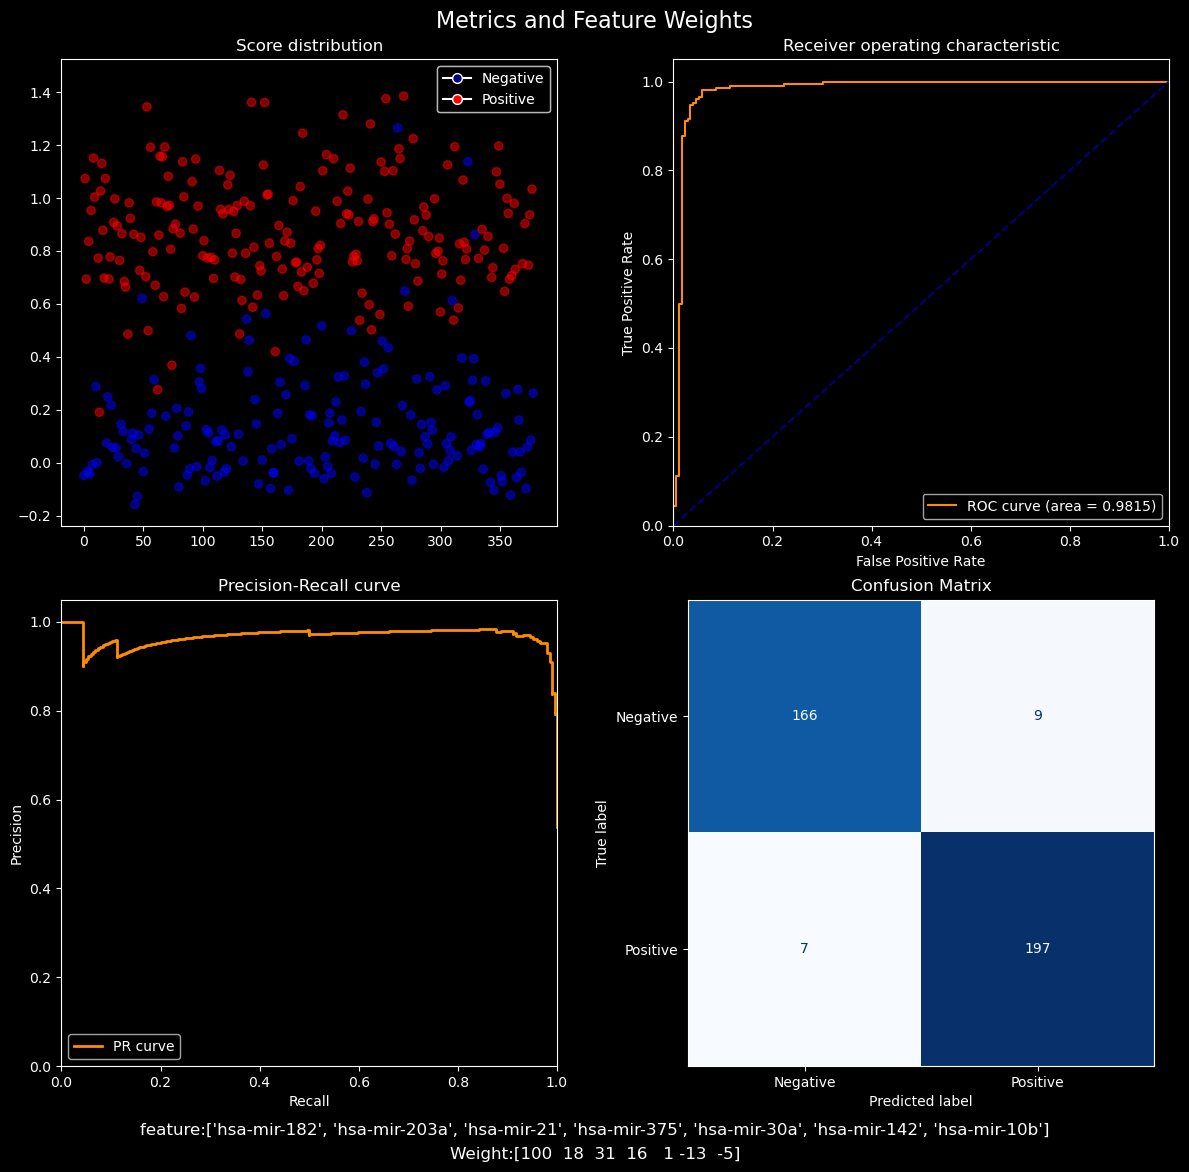

In [281]:
weight_int = np.array(weight, dtype=int)
plot_metrics(testdata_weight, feature, weight_int)